In [2]:
%cd ../

e:\python\atomization-energy-regression


In [3]:
from src.data_processing.molecule import get_molecule_name 
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

In [261]:
data = scipy.io.loadmat('dataset\qm7.mat')
X = data['X'] # Coulomb matrices -> 7165 x 23 x 23
T = data['T'].T.squeeze() # atomization energies Y -> 7165 x 1
Z = data['Z'] # atomic charge -> 7165 x 23
R = data['R'] # cartesian coordinates -> 7165 x 23 x 3
data_train, data_test = {}, {}
molecule_name = get_molecule_name(data)
Y = T
y_scaling_factor = np.max(np.absolute(Y))
Y = Y / y_scaling_factor

In [6]:
def feature_engineer(data):
    X = data['X'] # Coulomb matrices -> 7165 x 23 x 23
    T = data['T'].T.squeeze() # atomization energies Y -> 7165 x 1
    Z = data['Z'] # atomic charge -> 7165 x 23
    R = data['R'] # cartesian coordinates -> 7165 x 23 x 3
    data_train, data_test = {}, {}
    molecule_name = get_molecule_name(data)
    
    
    y = np.transpose(T)
    y_scaling_factor = np.max(np.absolute(y))
    y_scaled = y / y_scaling_factor
   
    features_vector = []
    for (x,z,r) in zip(X,Z,R):
        sorted_idx = np.argsort(np.linalg.norm(x, axis=1)) 
        sorted_coulomb_mat = x[sorted_idx, :]  # Sort rows
        sorted_coulomb_mat.sort(axis=1)
        order_x = sorted_coulomb_mat
        features_vector.append(np.concatenate((np.linalg.eigvals(x), list(nx.degree_centrality(nx.from_numpy_matrix(x)).values()), order_x.flatten(),z, r.mean(axis=0), r.std(axis=0))))
        # print(features_vector[-1].shape)
    return features_vector, y_scaled, y_scaling_factor

X, Y, min_max_scaler  = feature_engineer(data)
X = np.asarray(X)
Y = np.asarray(Y)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from src.solver import make_optimizer, make_scheduler
# import List
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLP, self).__init__()
        print(input_size)
        self.fc = nn.Sequential()
        self.fc.add_module("fc0", nn.Linear(input_size, hidden_sizes[0]))
        for idx, (in_size, out_size) in enumerate(zip(hidden_sizes[:-1], hidden_sizes[1:])):
            self.fc.add_module("fc{}".format(idx+1), nn.Linear(in_size, out_size))
            self.fc.add_module("relu{}".format(idx+1), nn.ReLU())

        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

In [ ]:
cfg = {
   'OPTIMIZER_NAME': 'SGD',
   'MOMENTUM': 0.9,
   'BASE_LR': 0.0001,
   'WEIGHT_DECAY': 1e-4,
   'BIAS_LR_FACTOR': 2,
   'WEIGHT_DECAY_BIAS': 1e-4,
   'WARMUP_METHOD': 'CosineAnnealing',

}  

In [262]:
from typing import Callable, Optional
import torch
from torch_geometric.data import Data, InMemoryDataset, download_url
from scipy.io import loadmat
data = loadmat('dataset\qm7.mat')
coulomb_matrix = torch.from_numpy(data['X'])
target = torch.from_numpy(data['T']).to(torch.float)
target = target.view(-1, 1)

Z = data['Z']
R = data['R']
# get node features
import networkx as nx

node_features = []
for i in range(coulomb_matrix.shape[0]):
    atom_charge = Z[i]
    coordinate = R[i]
    x = data['X'][i]
    # print(nx.degree_centrality(nx.from_numpy_matrix(x)).values())
    centrality = list(nx.degree_centrality(nx.from_numpy_matrix(x)).values())
    
    # print(centrality)
    feature = []
    for node_idx in range(coulomb_matrix.shape[1]):
        # print(coulomb_matrix[i, node_idx, :], atom_charge[node_idx], coordinate[node_idx, :], centrality[node_idx])
        # node_features.append(coulomb_matrix[i, node_idx, :])
        if abs(atom_charge[node_idx] - 0.0) < 1e-5:
            continue
        feature.append(np.array([atom_charge[node_idx], coordinate[node_idx, :][0], coordinate[node_idx, :][1], coordinate[node_idx, :][2] , centrality[node_idx]]))
    if len(feature) !=  np.sum(atom_charge!=0):
        print(i, len(feature), np.sum(atom_charge!=0))
    # break
    node_features.append(feature)

In [263]:
split = data['P'][0]
mask = np.zeros(Y.size, dtype=bool)
mask[split] = True

X_train = X[~mask]
y_train = Y[~mask]
X_test = X[mask]
y_test = Y[mask]
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
atom_charge_test = Z[mask]
# node_train = node_features[~mask]
# node_test = node_features[mask]

In [264]:
split.sort()

In [265]:
node_train = []
node_test = []
i = 0
for idx in split:
    node_test.append(np.asarray(node_features[idx]))
    # print(Z[idx], atom_charge_test[i])
    i += 1
for idx in range(len(node_features)):
    if idx not in split:
        node_train.append(np.asarray(node_features[idx]))

In [266]:
data_list = []
train_list = []
val_list = []
for i in range(y_train.shape[0]):
    edge_index = X_train[i].nonzero(
        as_tuple=False).t().contiguous()
    edge_attr = X_train[i, edge_index[0], edge_index[1]]
    y = y_train[i]
    y = torch.tensor(y)
    node_feature = node_train[i]
    node_feature = torch.tensor(node_feature)
    edge_index = torch.tensor(edge_index)

    edge_attr = torch.tensor(edge_attr)
    data = Data(x=node_feature, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.num_nodes = edge_index.max().item() + 1
    train_list.append(data)
    
    # print(i)
for i in range(y_test.shape[0]):
    edge_index = X_test[i].nonzero(
        as_tuple=False).t().contiguous()
    edge_attr = X_test[i, edge_index[0], edge_index[1]]
    y = y_test[i]
    y = torch.tensor(y)
    node_feature = node_test[i]
    if edge_index.max().item() > node_feature.shape[0]:
        print(node_feature.shape[0], edge_index.max().item(), i)
        print(edge_index)
        print(atom_charge_test[i])
        break
    # print(node_feature.shape[0], edge_index.max().item())
    node_feature = torch.tensor(node_feature)
    edge_index = torch.tensor(edge_index)
    edge_attr = torch.tensor(edge_attr)
    data = Data(x = node_feature,edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.num_nodes = edge_index.max().item() + 1
    val_list.append(data)
 

In [267]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_list, batch_size=64, shuffle=True)
test_loader = DataLoader(val_list, batch_size=64, shuffle=False)

In [1]:
from torch_geometric.datasets import Qm7


ImportError: cannot import name 'Qm7' from 'torch_geometric.datasets' (d:\Applications\Anaconda\envs\graph\lib\site-packages\torch_geometric\datasets\__init__.py)

In [268]:
for step, data in enumerate(test_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()
    break

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[831, 5], edge_index=[2, 11471], edge_attr=[11471], y=[64], num_nodes=831, batch=[831], ptr=[65])



In [269]:
train_loader.dataset[0].num_features
test_loader.dataset[0].num_features
# train_loader.num_classes

5

In [270]:
import warnings
warnings.filterwarnings('ignore')

In [285]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

class GCN(torch.nn.Module):
    def __init__(self,num_node_features, hidden_channels):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.conv1 = GraphConv(num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels//2)
        self.conv3 = GraphConv(hidden_channels//2, hidden_channels//4)
        self.sigmoid = torch.nn.Sigmoid()

        self.fc1 = Linear(hidden_channels//4, hidden_channels//8)
        self.fc2 = Linear(hidden_channels//8, 1)
        # self.lin = Linear(hidden_channels, 1)
        self.relu = torch.nn.ReLU()
    def forward(self, x, edge_index, batch):
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        # x = self.sigmoid(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = self.sigmoid(x)
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)

        # x = self.sigmoid(x)
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        
        return x
model = GCN(hidden_channels=40, num_node_features=train_loader.dataset[0].num_features)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # Define optimizer.
criterion = torch.nn.MSELoss()
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         out = model(data.x.float(), data.edge_index, data.batch, data.edg)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    predict_loss = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        
        out = model(data.x.float(), data.edge_index, data.batch)  
        mae = torch.nn.L1Loss()
        predict_loss.append(mae(out, data.y))
    return torch.mean(torch.stack(predict_loss))  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    test_acc = test(test_loader)
    train()
    train_acc = test(train_loader)
    
    print(f'Epoch: {epoch:03d}, Train MAE: {train_acc:.7f}, Test MAE: {test_acc:.7f}')
    scheduler.step()



Epoch: 001, Train MAE: 0.7842718, Test MAE: 164.3682556
Epoch: 002, Train MAE: 0.7813894, Test MAE: 0.7949787
Epoch: 003, Train MAE: 0.7775766, Test MAE: 0.7832549


KeyboardInterrupt: 

: 

In [25]:
f = open('./temp.txt', 'r')
f = f.readlines()
print(f[0])

Best loss at epoch 102 is 0.004382



In [26]:
results = []
epochs = []
for line in f:
    if 'Best loss at' not in line:
        continue
    results.append(float(line.split(' ')[-1]))
    # print(line.split(' ')[-3])
    epochs.append(int(line.split(' ')[-3]))

In [27]:
np.max(epochs)

914

In [28]:
import numpy as np
np.min(results)

0.002278

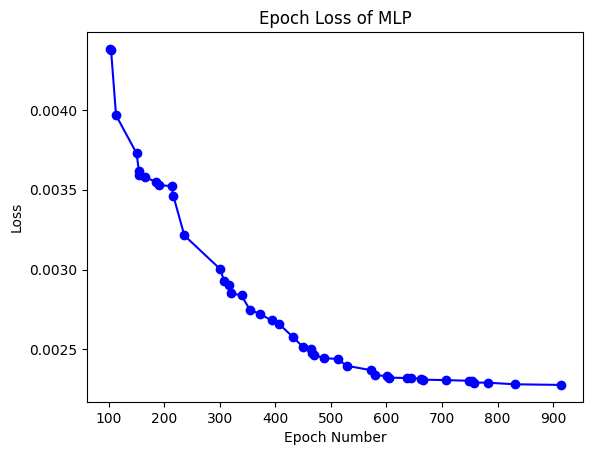

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(epochs, results, 'b-o') # plot the data as blue lines with circles at each point
plt.title('Epoch Loss of MLP') # set the title of the plot
plt.xlabel('Epoch Number') # set the label for the x-axis
plt.ylabel('Loss') # set the label for the y-axis
plt.show() # display the plot

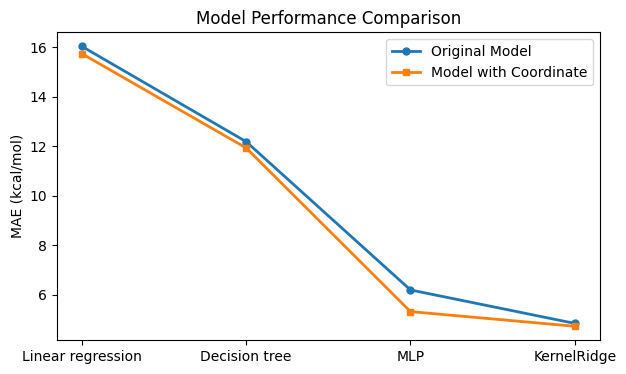

In [39]:
models = ['Linear regression', 'Decision tree','SVR', 'MLP', 'KernelRidge']
results1 = [16.029, 12.180642094582174,6.290328807647262, 6.1924,4.8409724025498235]
results2_coor = [15.734715584256172, 11.9269,6.119943976807257,5.3183,4.725853409328521]


fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(models))
ax.plot(x, results1, marker='o', markersize=5, linewidth=2, label='Original Model')
ax.plot(x, results2_coor, marker='s', markersize=5, linewidth=2, label='Model with Coordinate')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('MAE (kcal/mol)')
ax.set_title('Model Performance Comparison')
ax.legend()

# times =
'''
SVR: 165.23628163337708
KRR: 15.338593006134033

'''